In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def train_test_split(df, train_ratio, X, y, random = False, dtrain = False):
    """
    Argument
    df : DataFrame object
    train_ratio : float, in range(0,1)
    X : sequence data, such as list, tuple (Train Features)
    y : str
    random : boolean, you need "numpy" library cause we use np.random.permutation function.
    
    Return
    train : 학습시킬 Feature data
    train_idx : 지도학습의 Y value
    test : test 검증할 Feature data
    test_idx : test set의 Y value
    """
    train_size = int(len(df)*train_ratio)
    if random:
        shuffle_indicies = np.random.permutation(len(df))
        train_indicies = shuffle_indicies[:train_size]
        test_indicies = shuffle_indicies[train_size:]
    else:
        normal_indicies = np.arange(len(df))
        train_indicies = normal_indicies[:train_size]
        test_indicies = normal_indicies[train_size:]
    if dtrain:
        train = df.iloc[:train_size]
        train_idx = df.iloc[:train_size]
        test = df.iloc[train_size:]
        test_idx = df.iloc[train_size:]
    else:
        train = df.iloc[:train_size][X]
        train_idx = df.iloc[:train_size][y]
        test = df.iloc[train_size:][X]
        test_idx = df.iloc[train_size:][y]
    return train, train_idx, test, test_idx

In [2]:
kospi200 = pd.read_csv("./data/data.csv", encoding="cp949")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

name_dict = { i : j for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }
code_dict = { j : i for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }

In [3]:
import pickle
with open('raw_data_20180824.pickle','rb') as handle:
    raw_data = pickle.load(handle)

In [4]:
party_df = pd.read_csv('party_df.csv')
party_df["종목코드"] = party_df["종목코드"].map('{:06d}'.format)

In [5]:
del_li = [key for key, df in raw_data.items() if len(df) < 252*2]
for code in del_li:
    del raw_data[code]

In [6]:
print([code_dict[i] for i in del_li],end=" ")

['BGF리테일', 'HDC현대산업개발', 'SK케미칼', '넷마블', '두산밥캣', '삼성바이오로직스', '오리온', '현대중공업지주', '효성중공업'] 

In [10]:
from sklearn.svm import SVC

In [12]:
a = SVC()

In [20]:
str(a)[:3]

'SVC'

In [29]:
def test(model):
    test2(model)
    
def test2(model):
    print(model)

In [30]:
test(50)

50


In [31]:
test = {'005930':{'xgb':[1,2,3,4,5], 'svc':[6,7,8,9,10]},
        '006800':{'xgb':['a','b','c','d','e'], 'svc':['f','g','h','i','j']}}

In [34]:
xgb = {}
for key in test.keys():
    xgb[key] = test[key]['xgb']

In [35]:
xgb

{'005930': [1, 2, 3, 4, 5], '006800': ['a', 'b', 'c', 'd', 'e']}

In [8]:
party = party_df[[i not in del_li for i in party_df.loc[:,'종목코드']]]

In [9]:
party.income.value_counts()

low             49
middle          49
lower middle    43
high            30
upper middle    22
Name: income, dtype: int64

In [10]:
party.업종.value_counts()

경기소비재    38
생활소비재    35
에너지화학    24
헬스케어     17
금융       17
정보기술     15
산업재      15
건설       13
철강소재     10
중공업       9
Name: 업종, dtype: int64

In [11]:
raw_data[name_dict['삼성전자']].duplicated().sum()

26

In [12]:
len(raw_data.keys())

193

In [13]:
for code in raw_data.keys():
    """
    X
    """
    raw_data[code]["pct_change"] = raw_data[code].Close.pct_change().shift(1)
    for i in range(3, 31):
        raw_data[code]["close_ma_{}".format(i)] = raw_data[code].Close.rolling(window = i).mean().shift(1)
        raw_data[code]["volume_ma_{}".format(i)] =  raw_data[code].Volume.rolling(window = i).mean().shift(1)
    for i in [7, 21, 30, 60, 90, 91, 100, 120]:
        raw_data[code]["his_vol_{}".format(i)] = raw_data[code]["pct_change"].fillna(0).rolling(window = i).std().shift(1)*(252**0.5)
    """
    Y
    """
    
    raw_data[code] = raw_data[code].assign(Y1 = raw_data[code].Close - raw_data[code].close_ma_7.shift(1))
    raw_data[code] = raw_data[code].assign(Y2 =
                                           raw_data[code]["pct_change"] - raw_data[code]["pct_change"].rolling(window = 7).mean().shift(1))
    raw_data[code] = raw_data[code].assign(Y3 = raw_data[code].Close.rolling(window=7).sum().pct_change())
    
    raw_data[code] = raw_data[code].assign(Y1 = np.where(raw_data[code].Y1>=0, 1, 0))
    raw_data[code] = raw_data[code].assign(Y2 = np.where(raw_data[code].Y2>=0, 1, 0))
    raw_data[code] = raw_data[code].assign(Y3 = np.where(raw_data[code].Y3>=0, 1, 0))
    """
    Drop NaN
    """
    raw_data[code] = raw_data[code].dropna(axis=0)

In [14]:
data = {}
for code in raw_data.keys():
    data[code] = raw_data[code].copy()
    data[code]['Close'] = data[code]['Close'].shift(1)
    data[code]['High'] = data[code]['High'].shift(1)
    data[code]['Low'] = data[code]['Low'].shift(1)
    data[code]['Adj Close'] = data[code]['Adj Close'].shift(1)
    data[code]['Volume'] = data[code]['Volume'].shift(1)
    data[code] = data[code].loc['2012-01-01':'2018-07-31']
    data[code] = data[code].dropna(axis=0)

In [15]:
trial = 1
for i in data.keys():
    if (data[i][['Close','Volume', 'Open']].duplicated().sum() > 20):
        print(trial, code_dict[i])
        trial += 1

1 BGF
2 HDC
3 SK디스커버리
4 대우조선해양
5 대한항공
6 동아쏘시오홀딩스
7 동양
8 롯데지주
9 오리온홀딩스
10 우리은행
11 쿠쿠홀딩스
12 팬오션
13 한국타이어월드와이드
14 한라홀딩스
15 현대중공업
16 효성


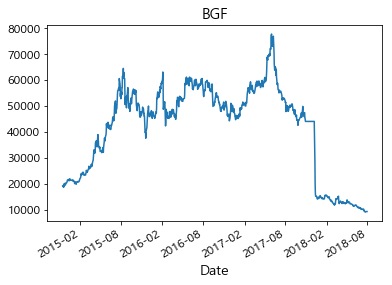

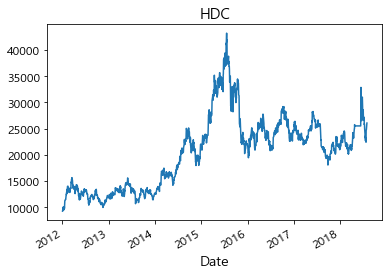

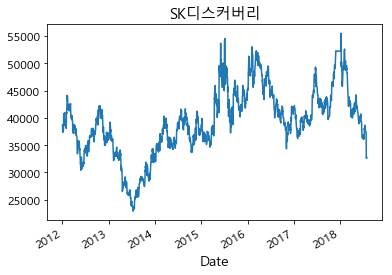

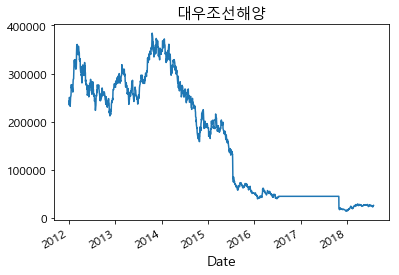

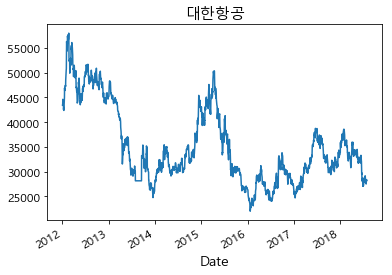

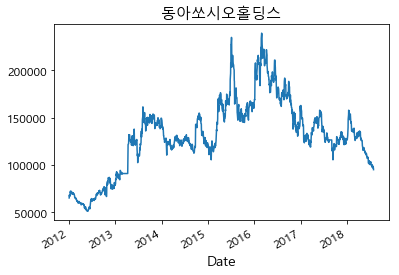

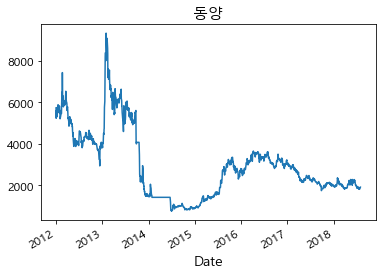

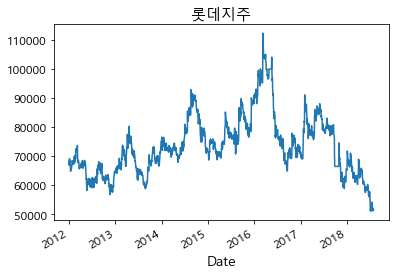

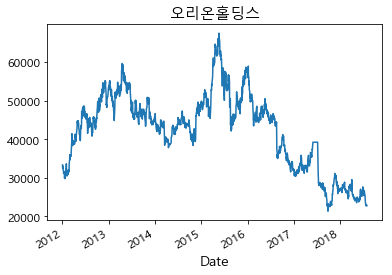

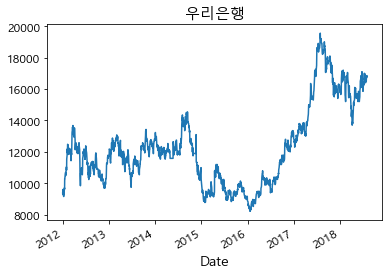

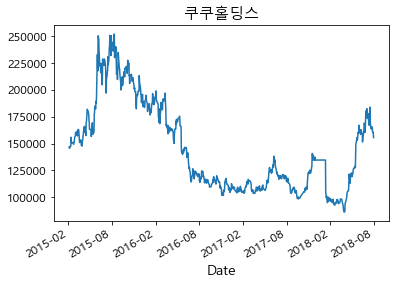

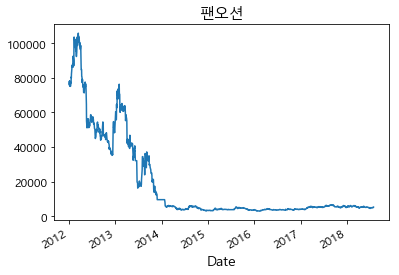

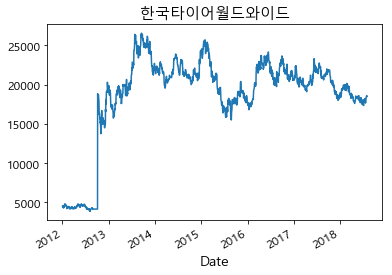

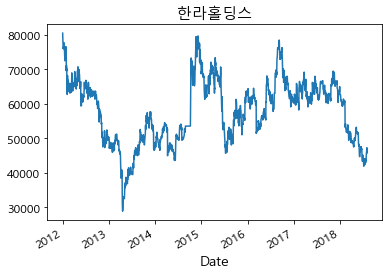

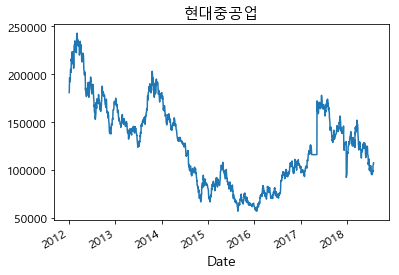

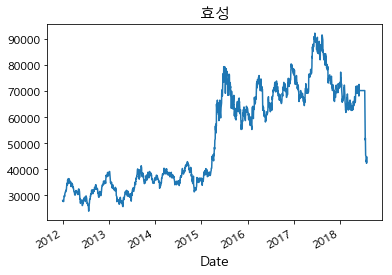

In [40]:
for i in data.keys():
    if (data[i][['Close','Volume', 'Open']].duplicated().sum() > 20):
        data[i]['Close'].plot()
        plt.title(code_dict[i], fontsize=15)
        plt.show()

In [16]:
del_li = [key for key, df in data.items() \
          if (df[['Close','Volume','Open']].duplicated().sum()>20)]
for code in del_li:
    del data[code]

In [17]:
len(data)

177

In [21]:
predictors = [x for x in data['005930'].columns if x not in ['Y1','Y2','Y3']]
target = "Y2"

In [22]:
train = {}
train_y = {}
test = {}
test_y = {}
for code, df in data.items():
    X_train, y_train, X_test, y_test = train_test_split(df, 0.8, predictors, target, dtrain=True)
    train[code] = X_train
    train_y[code] = y_train
    test[code] = X_test
    test_y[code] = y_test

In [24]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb_clf = XGBClassifier(random_state=42)

In [56]:
alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
import time

In [64]:
cv_folds=5
early_stopping_rounds=50

stock_alg = {}
start = time.time()
for i in data.keys():
    semi_start = time.time()
    alg = XGBClassifier(
         learning_rate =0.15,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         nthread=4,
         scale_pos_weight=1,
         seed=27)
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train[i][predictors].values, label=train[i][target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
    alg.set_params(n_estimators=cvresult.shape[0])
    stock_alg[i] = alg
    semi_elapse = time.time() - semi_start
    elapse = time.time() - start
    print(code_dict[i], 'n_estimators = {}'.format(cvresult.shape[0]))
    if elapse > 60:
        print('지금까지 걸린 시간 {} min\t'.format(round(elapse/60,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    elif elapse > 3600:
        print('지금까지 걸린 시간 {} hour\t'.format(round(elapse/3600,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    else:
        print('지금까지 걸린 시간 {} sec\t'.format(round(elapse,2)), '(+ {} sec)'.format(round(semi_elapse,2)))

AK홀딩스 n_estimators = 112
지금까지 걸린 시간 3.44 sec	 (+ 3.44 sec)
BNK금융지주 n_estimators = 90
지금까지 걸린 시간 6.52 sec	 (+ 3.08 sec)
CJ n_estimators = 70
지금까지 걸린 시간 8.97 sec	 (+ 2.45 sec)
CJ CGV n_estimators = 156
지금까지 걸린 시간 12.96 sec	 (+ 3.98 sec)
CJ대한통운 n_estimators = 121
지금까지 걸린 시간 16.26 sec	 (+ 3.3 sec)
CJ제일제당 n_estimators = 257
지금까지 걸린 시간 21.45 sec	 (+ 5.19 sec)
DB손해보험 n_estimators = 261
지금까지 걸린 시간 26.7 sec	 (+ 5.25 sec)
DB하이텍 n_estimators = 283
지금까지 걸린 시간 32.51 sec	 (+ 5.81 sec)
GKL n_estimators = 90
지금까지 걸린 시간 35.3 sec	 (+ 2.79 sec)
GS n_estimators = 216
지금까지 걸린 시간 40.5 sec	 (+ 5.2 sec)
GS건설 n_estimators = 147
지금까지 걸린 시간 44.34 sec	 (+ 3.84 sec)
GS리테일 n_estimators = 176
지금까지 걸린 시간 48.25 sec	 (+ 3.9 sec)
JW중외제약 n_estimators = 114
지금까지 걸린 시간 51.55 sec	 (+ 3.3 sec)
JW홀딩스 n_estimators = 143
지금까지 걸린 시간 55.4 sec	 (+ 3.85 sec)
KB금융 n_estimators = 94
지금까지 걸린 시간 58.26 sec	 (+ 2.86 sec)
KCC n_estimators = 280
지금까지 걸린 시간 1.06 min	 (+ 5.54 sec)
KT n_estimators = 193
지금까지 걸린 시간 1.13 min	 (+ 4.26 sec)
KT&G 

한국타이어 n_estimators = 107
지금까지 걸린 시간 9.82 min	 (+ 2.59 sec)
한국항공우주 n_estimators = 144
지금까지 걸린 시간 9.89 min	 (+ 3.84 sec)
한미사이언스 n_estimators = 159
지금까지 걸린 시간 9.96 min	 (+ 4.2 sec)
한미약품 n_estimators = 178
지금까지 걸린 시간 10.04 min	 (+ 4.76 sec)
한샘 n_estimators = 165
지금까지 걸린 시간 10.11 min	 (+ 4.55 sec)
한섬 n_estimators = 79
지금까지 걸린 시간 10.16 min	 (+ 2.89 sec)
한세실업 n_estimators = 59
지금까지 걸린 시간 10.2 min	 (+ 2.65 sec)
한솔케미칼 n_estimators = 229
지금까지 걸린 시간 10.3 min	 (+ 5.83 sec)
한온시스템 n_estimators = 101
지금까지 걸린 시간 10.36 min	 (+ 3.81 sec)
한올바이오파마 n_estimators = 303
지금까지 걸린 시간 10.49 min	 (+ 7.58 sec)
한일시멘트 n_estimators = 138
지금까지 걸린 시간 10.56 min	 (+ 4.24 sec)
한전KPS n_estimators = 180
지금까지 걸린 시간 10.65 min	 (+ 5.13 sec)
한전기술 n_estimators = 309
지금까지 걸린 시간 10.77 min	 (+ 7.37 sec)
한진중공업 n_estimators = 178
지금까지 걸린 시간 10.85 min	 (+ 4.96 sec)
한화 n_estimators = 287
지금까지 걸린 시간 10.96 min	 (+ 6.51 sec)
한화생명 n_estimators = 262
지금까지 걸린 시간 11.06 min	 (+ 5.97 sec)
한화에어로스페이스 n_estimators = 280
지금까지 걸린 시간 11.17 min	 (+ 6.6

In [65]:
stock_alg['005930']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=126,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [67]:
param_test1 = {
 'max_depth':range(3,10,2), # 3 5 7 9
 'min_child_weight':range(1,6,2) # 1 3 5
}

result = {}
total_elapse = 0
start = time.time()
for i in data.keys():
    semi_start = time.time()
    gsearch = GridSearchCV(estimator = stock_alg[i], 
         param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
    gsearch.fit(train[i][predictors],train[i][target])
    result[i] = (gsearch.best_params_, gsearch.best_score_)
    print(code_dict[i])
    semi_elapse = time.time() - semi_start
    elapse = time.time() - start
    if elapse > 60:
        print('지금까지 걸린 시간 {} min\t'.format(round(elapse/60,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    elif elapse > 3600:
        print('지금까지 걸린 시간 {} hour\t'.format(round(elapse/3600,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    else:
        print('지금까지 걸린 시간 {} sec\t'.format(round(elapse,2)), '(+ {} sec)'.format(round(semi_elapse,2)))

AK홀딩스
지금까지 걸린 시간 22.54 sec	 (+ 22.54 sec)
BNK금융지주
지금까지 걸린 시간 41.96 sec	 (+ 19.42 sec)
CJ
지금까지 걸린 시간 58.92 sec	 (+ 16.96 sec)
CJ CGV
지금까지 걸린 시간 1.47 min	 (+ 29.34 sec)
CJ대한통운
지금까지 걸린 시간 1.94 min	 (+ 28.39 sec)
CJ제일제당
지금까지 걸린 시간 2.58 min	 (+ 38.38 sec)
DB손해보험
지금까지 걸린 시간 3.22 min	 (+ 38.42 sec)
DB하이텍
지금까지 걸린 시간 3.98 min	 (+ 45.21 sec)
GKL
지금까지 걸린 시간 4.34 min	 (+ 21.54 sec)
GS
지금까지 걸린 시간 4.94 min	 (+ 36.21 sec)
GS건설
지금까지 걸린 시간 5.41 min	 (+ 28.39 sec)
GS리테일
지금까지 걸린 시간 5.91 min	 (+ 29.86 sec)
JW중외제약
지금까지 걸린 시간 6.35 min	 (+ 26.11 sec)
JW홀딩스
지금까지 걸린 시간 6.86 min	 (+ 30.72 sec)
KB금융
지금까지 걸린 시간 7.3 min	 (+ 26.62 sec)
KCC
지금까지 걸린 시간 8.0 min	 (+ 41.99 sec)
KT
지금까지 걸린 시간 8.58 min	 (+ 34.42 sec)
KT&G
지금까지 걸린 시간 8.92 min	 (+ 20.85 sec)
LF
지금까지 걸린 시간 9.49 min	 (+ 34.17 sec)
LG
지금까지 걸린 시간 9.85 min	 (+ 21.75 sec)
LG디스플레이
지금까지 걸린 시간 10.7 min	 (+ 50.68 sec)
LG상사
지금까지 걸린 시간 11.45 min	 (+ 45.32 sec)
LG생활건강
지금까지 걸린 시간 11.94 min	 (+ 29.34 sec)
LG유플러스
지금까지 걸린 시간 12.35 min	 (+ 24.53 sec)
LG이노텍
지금까지 걸린 시간 13.18 m

In [84]:
pd.Series([result[code][0]['max_depth'] for code in data.keys()]).value_counts()

3    121
5     24
7     17
9     15
dtype: int64

In [85]:
pd.Series([result[code][0]['min_child_weight'] for code in data.keys()]).value_counts()

3    72
1    68
5    37
dtype: int64

In [86]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3,4]
}

result2 = {}
total_elapse = 0
trial = 0
start = time.time()
for i in data.keys():
    trial += 1
    semi_start = time.time()
    gsearch = GridSearchCV(estimator = stock_alg[i], 
         param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
    gsearch.fit(train[i][predictors],train[i][target])
    result2[i] = (gsearch.best_params_, gsearch.best_score_)
    print(trial, '번째', code_dict[i])
    semi_elapse = time.time() - semi_start
    elapse = time.time() - start
    if elapse > 3600:
        print('지금까지 걸린 시간 {} hour\t'.format(round(elapse/3600,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    elif elapse > 60:
        print('지금까지 걸린 시간 {} min\t'.format(round(elapse/60,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    else:
        print('지금까지 걸린 시간 {} sec\t'.format(round(elapse,2)), '(+ {} sec)'.format(round(semi_elapse,2)))

1 번째 AK홀딩스
지금까지 걸린 시간 15.6 sec	 (+ 15.6 sec)
2 번째 BNK금융지주
지금까지 걸린 시간 29.29 sec	 (+ 13.69 sec)
3 번째 CJ
지금까지 걸린 시간 40.87 sec	 (+ 11.58 sec)
4 번째 CJ CGV
지금까지 걸린 시간 1.07 min	 (+ 23.26 sec)
5 번째 CJ대한통운
지금까지 걸린 시간 1.35 min	 (+ 16.73 sec)
6 번째 CJ제일제당
지금까지 걸린 시간 1.83 min	 (+ 28.97 sec)
7 번째 DB손해보험
지금까지 걸린 시간 2.31 min	 (+ 28.9 sec)
8 번째 DB하이텍
지금까지 걸린 시간 2.84 min	 (+ 31.86 sec)
9 번째 GKL
지금까지 걸린 시간 3.08 min	 (+ 14.31 sec)
10 번째 GS
지금까지 걸린 시간 3.51 min	 (+ 25.94 sec)
11 번째 GS건설
지금까지 걸린 시간 3.91 min	 (+ 23.74 sec)
12 번째 GS리테일
지금까지 걸린 시간 4.26 min	 (+ 20.84 sec)
13 번째 JW중외제약
지금까지 걸린 시간 4.54 min	 (+ 16.72 sec)
14 번째 JW홀딩스
지금까지 걸린 시간 4.87 min	 (+ 19.82 sec)
15 번째 KB금융
지금까지 걸린 시간 5.11 min	 (+ 14.59 sec)
16 번째 KCC
지금까지 걸린 시간 5.64 min	 (+ 31.87 sec)
17 번째 KT
지금까지 걸린 시간 6.1 min	 (+ 27.64 sec)
18 번째 KT&G
지금까지 걸린 시간 6.35 min	 (+ 15.11 sec)
19 번째 LF
지금까지 걸린 시간 6.68 min	 (+ 19.61 sec)
20 번째 LG
지금까지 걸린 시간 6.93 min	 (+ 15.05 sec)
21 번째 LG디스플레이
지금까지 걸린 시간 7.49 min	 (+ 33.27 sec)
22 번째 LG상사
지금까지 걸린 시간 8.02 min	 (+ 3

174 번째 현대홈쇼핑
지금까지 걸린 시간 1.06 hour	 (+ 17.44 sec)
175 번째 호텔신라
지금까지 걸린 시간 1.07 hour	 (+ 26.27 sec)
176 번째 후성
지금까지 걸린 시간 1.07 hour	 (+ 20.97 sec)
177 번째 휴켐스
지금까지 걸린 시간 1.08 hour	 (+ 24.72 sec)


In [87]:
pd.Series([result2[code][0]['max_depth'] for code in data.keys()]).value_counts()

2    106
3     40
4     31
dtype: int64

In [97]:
pd.DataFrame([result2[code][0] for code in data.keys()])[[i==2 for i in [result2[code][0]['max_depth'] for code in data.keys()]]]['min_child_weight'].value_counts()

2    34
1    28
3    27
4    17
Name: min_child_weight, dtype: int64

In [88]:
pd.Series([result2[code][0]['min_child_weight'] for code in data.keys()]).value_counts()

2    54
1    52
3    44
4    27
dtype: int64

In [113]:
def MultiGreadSearchXGB(train, alg, param, predictors, target, scoring='roc_auc', cv=5):
    res = {}
    trial = 0
    start = time.time()
    for i in train.keys():
        trial += 1
        semi_start = time.time()
        gsearch = GridSearchCV(estimator = alg[i], 
             param_grid = param, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
        gsearch.fit(train[i][predictors],train[i][target])
        res[i] = (gsearch.best_params_, round(gsearch.best_score_,4))
        print(trial, '번째', code_dict[i], res[i])
        semi_elapse = time.time() - semi_start
        elapse = time.time() - start
        if elapse > 3600:
            print(' 지금까지 걸린 시간 {} hour\t'.format(round(elapse/3600,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
        elif elapse > 60:
            print(' 지금까지 걸린 시간 {} min\t'.format(round(elapse/60,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
        else:
            print(' 지금까지 걸린 시간 {} sec\t'.format(round(elapse,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
        print('')
    return res, elapse

In [119]:
for i in train.keys():
    stock_alg[i].set_params(max_depth = 2)

In [120]:
param_test2b = {'min_child_weight':[2,4,6,8,10,12]}
result2b, elapse2b = MultiGreadSearchXGB(train, stock_alg, param_test2b, predictors, target)

1 번째 AK홀딩스 ({'min_child_weight': 2}, 0.958)
 지금까지 걸린 시간 9.34 sec	 (+ 9.34 sec)

2 번째 BNK금융지주 ({'min_child_weight': 4}, 0.9594)
 지금까지 걸린 시간 17.66 sec	 (+ 8.31 sec)

3 번째 CJ ({'min_child_weight': 10}, 0.9642)
 지금까지 걸린 시간 25.23 sec	 (+ 7.58 sec)

4 번째 CJ CGV ({'min_child_weight': 2}, 0.949)
 지금까지 걸린 시간 35.9 sec	 (+ 10.67 sec)

5 번째 CJ대한통운 ({'min_child_weight': 2}, 0.959)
 지금까지 걸린 시간 45.57 sec	 (+ 9.67 sec)

6 번째 CJ제일제당 ({'min_child_weight': 4}, 0.9623)
 지금까지 걸린 시간 59.96 sec	 (+ 14.4 sec)

7 번째 DB손해보험 ({'min_child_weight': 2}, 0.9623)
 지금까지 걸린 시간 1.24 min	 (+ 14.53 sec)

8 번째 DB하이텍 ({'min_child_weight': 6}, 0.9569)
 지금까지 걸린 시간 1.5 min	 (+ 15.57 sec)

9 번째 GKL ({'min_child_weight': 4}, 0.9597)
 지금까지 걸린 시간 1.65 min	 (+ 8.68 sec)

10 번째 GS ({'min_child_weight': 6}, 0.9581)
 지금까지 걸린 시간 1.87 min	 (+ 13.65 sec)

11 번째 GS건설 ({'min_child_weight': 4}, 0.9594)
 지금까지 걸린 시간 2.11 min	 (+ 14.31 sec)

12 번째 GS리테일 ({'min_child_weight': 2}, 0.9617)
 지금까지 걸린 시간 2.31 min	 (+ 11.85 sec)

13 번째 JW중외제약 ({'min_c

101 번째 세방전지 ({'min_child_weight': 4}, 0.9611)
 지금까지 걸린 시간 20.13 min	 (+ 13.98 sec)

102 번째 세아베스틸 ({'min_child_weight': 8}, 0.9512)
 지금까지 걸린 시간 20.39 min	 (+ 15.64 sec)

103 번째 세아제강 ({'min_child_weight': 6}, 0.9587)
 지금까지 걸린 시간 20.63 min	 (+ 14.68 sec)

104 번째 셀트리온 ({'min_child_weight': 4}, 0.947)
 지금까지 걸린 시간 20.85 min	 (+ 12.86 sec)

105 번째 신세계 ({'min_child_weight': 2}, 0.9647)
 지금까지 걸린 시간 21.0 min	 (+ 9.07 sec)

106 번째 신한지주 ({'min_child_weight': 2}, 0.971)
 지금까지 걸린 시간 21.18 min	 (+ 10.99 sec)

107 번째 쌍용양회 ({'min_child_weight': 2}, 0.9461)
 지금까지 걸린 시간 21.39 min	 (+ 12.79 sec)

108 번째 쌍용차 ({'min_child_weight': 2}, 0.9498)
 지금까지 걸린 시간 21.57 min	 (+ 10.3 sec)

109 번째 아모레G ({'min_child_weight': 2}, 0.9498)
 지금까지 걸린 시간 21.76 min	 (+ 11.49 sec)

110 번째 아모레퍼시픽 ({'min_child_weight': 4}, 0.9459)
 지금까지 걸린 시간 21.96 min	 (+ 12.33 sec)

111 번째 아이에스동서 ({'min_child_weight': 10}, 0.9384)
 지금까지 걸린 시간 22.15 min	 (+ 11.21 sec)

112 번째 에스엘 ({'min_child_weight': 2}, 0.9709)
 지금까지 걸린 시간 22.34 min	 (+ 11.43 

In [121]:
pd.Series([result2b[code][0]['min_child_weight'] for code in data.keys()]).value_counts()

2     95
4     45
6     19
8      8
10     6
12     4
dtype: int64

In [122]:
param_test2c = {'min_child_weight':[2,3,4]}
result2c, elapse2c = MultiGreadSearchXGB(train, stock_alg, param_test2c, predictors, target)

1 번째 AK홀딩스 ({'min_child_weight': 2}, 0.958)
 지금까지 걸린 시간 7.9 sec	 (+ 7.9 sec)

2 번째 BNK금융지주 ({'min_child_weight': 4}, 0.9594)
 지금까지 걸린 시간 17.27 sec	 (+ 9.36 sec)

3 번째 CJ ({'min_child_weight': 4}, 0.9618)
 지금까지 걸린 시간 23.56 sec	 (+ 6.29 sec)

4 번째 CJ CGV ({'min_child_weight': 2}, 0.949)
 지금까지 걸린 시간 31.84 sec	 (+ 8.28 sec)

5 번째 CJ대한통운 ({'min_child_weight': 2}, 0.959)
 지금까지 걸린 시간 38.98 sec	 (+ 7.14 sec)

6 번째 CJ제일제당 ({'min_child_weight': 4}, 0.9623)
 지금까지 걸린 시간 49.07 sec	 (+ 10.09 sec)

7 번째 DB손해보험 ({'min_child_weight': 2}, 0.9623)
 지금까지 걸린 시간 59.2 sec	 (+ 10.14 sec)

8 번째 DB하이텍 ({'min_child_weight': 4}, 0.9561)
 지금까지 걸린 시간 1.16 min	 (+ 10.66 sec)

9 번째 GKL ({'min_child_weight': 3}, 0.9599)
 지금까지 걸린 시간 1.28 min	 (+ 7.01 sec)

10 번째 GS ({'min_child_weight': 3}, 0.9585)
 지금까지 걸린 시간 1.44 min	 (+ 9.29 sec)

11 번째 GS건설 ({'min_child_weight': 4}, 0.9594)
 지금까지 걸린 시간 1.57 min	 (+ 8.13 sec)

12 번째 GS리테일 ({'min_child_weight': 2}, 0.9617)
 지금까지 걸린 시간 1.71 min	 (+ 8.28 sec)

13 번째 JW중외제약 ({'min_child

102 번째 세아베스틸 ({'min_child_weight': 4}, 0.9505)
 지금까지 걸린 시간 15.37 min	 (+ 9.74 sec)

103 번째 세아제강 ({'min_child_weight': 4}, 0.9573)
 지금까지 걸린 시간 15.5 min	 (+ 7.75 sec)

104 번째 셀트리온 ({'min_child_weight': 4}, 0.947)
 지금까지 걸린 시간 15.69 min	 (+ 11.7 sec)

105 번째 신세계 ({'min_child_weight': 2}, 0.9647)
 지금까지 걸린 시간 15.84 min	 (+ 8.87 sec)

106 번째 신한지주 ({'min_child_weight': 2}, 0.971)
 지금까지 걸린 시간 15.98 min	 (+ 8.25 sec)

107 번째 쌍용양회 ({'min_child_weight': 2}, 0.9461)
 지금까지 걸린 시간 16.13 min	 (+ 8.96 sec)

108 번째 쌍용차 ({'min_child_weight': 2}, 0.9498)
 지금까지 걸린 시간 16.26 min	 (+ 7.77 sec)

109 번째 아모레G ({'min_child_weight': 3}, 0.9503)
 지금까지 걸린 시간 16.39 min	 (+ 8.19 sec)

110 번째 아모레퍼시픽 ({'min_child_weight': 3}, 0.9471)
 지금까지 걸린 시간 16.54 min	 (+ 8.89 sec)

111 번째 아이에스동서 ({'min_child_weight': 2}, 0.9348)
 지금까지 걸린 시간 16.68 min	 (+ 8.3 sec)

112 번째 에스엘 ({'min_child_weight': 3}, 0.9712)
 지금까지 걸린 시간 16.82 min	 (+ 8.31 sec)

113 번째 에스원 ({'min_child_weight': 2}, 0.9545)
 지금까지 걸린 시간 16.96 min	 (+ 8.47 sec)

114 번째 

In [123]:
pd.Series([result2c[code][0]['min_child_weight'] for code in data.keys()]).value_counts()

2    76
3    58
4    43
dtype: int64

In [125]:
for i in train.keys():
    stock_alg[i].set_params(min_child_weight = 2)

In [126]:
param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}
result3, elapse3 = MultiGreadSearchXGB(train, stock_alg, param_test3, predictors, target)

1 번째 AK홀딩스 ({'gamma': 0.4}, 0.9585)
 지금까지 걸린 시간 9.01 sec	 (+ 9.01 sec)

2 번째 BNK금융지주 ({'gamma': 0.0}, 0.9586)
 지금까지 걸린 시간 17.02 sec	 (+ 8.0 sec)

3 번째 CJ ({'gamma': 0.1}, 0.9609)
 지금까지 걸린 시간 24.42 sec	 (+ 7.41 sec)

4 번째 CJ CGV ({'gamma': 0.0}, 0.949)
 지금까지 걸린 시간 34.49 sec	 (+ 10.07 sec)

5 번째 CJ대한통운 ({'gamma': 0.0}, 0.959)
 지금까지 걸린 시간 43.68 sec	 (+ 9.19 sec)

6 번째 CJ제일제당 ({'gamma': 0.2}, 0.9613)
 지금까지 걸린 시간 59.93 sec	 (+ 16.25 sec)

7 번째 DB손해보험 ({'gamma': 0.1}, 0.9634)
 지금까지 걸린 시간 1.22 min	 (+ 13.5 sec)

8 번째 DB하이텍 ({'gamma': 0.4}, 0.9545)
 지금까지 걸린 시간 1.47 min	 (+ 14.54 sec)

9 번째 GKL ({'gamma': 0.0}, 0.9586)
 지금까지 걸린 시간 1.6 min	 (+ 8.24 sec)

10 번째 GS ({'gamma': 0.0}, 0.9575)
 지금까지 걸린 시간 1.81 min	 (+ 12.18 sec)

11 번째 GS건설 ({'gamma': 0.4}, 0.9598)
 지금까지 걸린 시간 1.98 min	 (+ 10.13 sec)

12 번째 GS리테일 ({'gamma': 0.4}, 0.962)
 지금까지 걸린 시간 2.15 min	 (+ 10.73 sec)

13 번째 JW중외제약 ({'gamma': 0.3}, 0.966)
 지금까지 걸린 시간 2.31 min	 (+ 9.07 sec)

14 번째 JW홀딩스 ({'gamma': 0.1}, 0.9419)
 지금까지 걸린 시간 2.47 min

113 번째 에스원 ({'gamma': 0.1}, 0.9548)
 지금까지 걸린 시간 22.73 min	 (+ 12.29 sec)

114 번째 엔씨소프트 ({'gamma': 0.0}, 0.9548)
 지금까지 걸린 시간 22.92 min	 (+ 11.74 sec)

115 번째 영원무역 ({'gamma': 0.1}, 0.9574)
 지금까지 걸린 시간 23.12 min	 (+ 12.12 sec)

116 번째 영진약품 ({'gamma': 0.4}, 0.9666)
 지금까지 걸린 시간 23.26 min	 (+ 8.39 sec)

117 번째 영풍 ({'gamma': 0.3}, 0.957)
 지금까지 걸린 시간 23.49 min	 (+ 13.54 sec)

118 번째 오뚜기 ({'gamma': 0.4}, 0.9525)
 지금까지 걸린 시간 23.74 min	 (+ 14.88 sec)

119 번째 유니드 ({'gamma': 0.3}, 0.9523)
 지금까지 걸린 시간 23.9 min	 (+ 9.73 sec)

120 번째 유한양행 ({'gamma': 0.0}, 0.9642)
 지금까지 걸린 시간 24.04 min	 (+ 8.28 sec)

121 번째 이노션 ({'gamma': 0.0}, 0.9306)
 지금까지 걸린 시간 24.15 min	 (+ 6.97 sec)

122 번째 이마트 ({'gamma': 0.4}, 0.9578)
 지금까지 걸린 시간 24.39 min	 (+ 13.91 sec)

123 번째 일양약품 ({'gamma': 0.2}, 0.9665)
 지금까지 걸린 시간 24.54 min	 (+ 9.47 sec)

124 번째 일진머티리얼즈 ({'gamma': 0.1}, 0.9661)
 지금까지 걸린 시간 24.79 min	 (+ 15.1 sec)

125 번째 제일기획 ({'gamma': 0.3}, 0.9686)
 지금까지 걸린 시간 24.94 min	 (+ 8.72 sec)

126 번째 종근당 ({'gamma': 0.2}, 0.9518)
 

In [127]:
pd.Series([result3[code][0]['gamma'] for code in data.keys()]).value_counts()

0.0    49
0.4    42
0.1    30
0.3    29
0.2    27
dtype: int64

In [143]:
def modelfit2(alg, dtrain, test, predictors, target, useTrainCV = True, 
             cv_folds = 5, early_stopping_rounds = 50, top = 10, 
             figure = True, model_report = True):
    
    start = time.time()
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    test_predictions = alg.predict(test[predictors])
    test_predprob = alg.predict_proba(test[predictors])[:,1]
        
    if model_report:
        #Print model report:
        print("Model Report")
        print("Accuracy (Train): %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print("Accuracy (Test): %.4g" % metrics.accuracy_score(test[target].values, test_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
        print("AUC Score (Test): %f" % metrics.roc_auc_score(test[target], test_predprob))
                    
    imp_fear_name = pd.Series(predictors)[alg.feature_importances_ > 0.01]
    imp_fear_name.index = range(len(imp_fear_name))
    imp_fear = pd.concat((imp_fear_name, 
               pd.Series(alg.feature_importances_[alg.feature_importances_ > 0.01])),axis=1).sort_values(by=1,ascending=True)
    imp_fear.index = range(len(imp_fear))
    imp_fear.columns = ["feature_name", "feature_importance"]
#     {i:j for i,j in zip(imp_fear.index, imp_fear["feature_name"])}
    if figure:
        if top:
            imp_fear.iloc[-top:].plot(y='feature_importance', x='feature_name', kind='barh', legend=False, figsize=(8,5))
        else:
            imp_fear.plot(y='feature_importance', x='feature_name', kind='barh', legend=False, figsize=(8,5))
    
#     feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances', figsize=(200,5))
#     plt.ylabel('Feature Importance Score')
    
    elapse = time.time() - start
    print("elapse time : {} sec".format(round(elapse,2)))
    
    return alg, imp_fear, elapse

In [144]:
from sklearn import metrics

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Report
Accuracy (Train): 0.9923
Accuracy (Test): 0.8858
AUC Score (Train): 0.999802
AUC Score (Test): 0.964257
elapse time : 3.75 sec


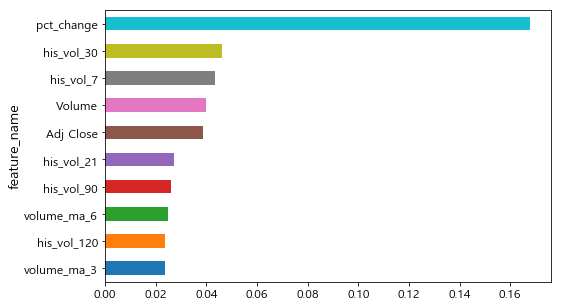

In [171]:
stock_name = '고려제강'
model, fear_importance, elapse = modelfit2(stock_alg[name_dict[stock_name]], train[name_dict[stock_name]], 
                                           test[name_dict[stock_name]], predictors, target, cv_folds=5, early_stopping_rounds=50)

In [173]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
result4, elapse4 = MultiGreadSearchXGB(train, stock_alg, param_test4, predictors, target)

1 번째 AK홀딩스 ({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.9606)
 지금까지 걸린 시간 21.34 sec	 (+ 21.34 sec)

2 번째 BNK금융지주 ({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9586)
 지금까지 걸린 시간 35.59 sec	 (+ 14.24 sec)

3 번째 CJ ({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.9638)
 지금까지 걸린 시간 48.0 sec	 (+ 12.41 sec)

4 번째 CJ CGV ({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.9506)
 지금까지 걸린 시간 1.15 min	 (+ 21.18 sec)

5 번째 CJ대한통운 ({'colsample_bytree': 0.7, 'subsample': 0.8}, 0.9596)
 지금까지 걸린 시간 1.44 min	 (+ 17.47 sec)

6 번째 CJ제일제당 ({'colsample_bytree': 0.6, 'subsample': 0.6}, 0.9625)
 지금까지 걸린 시간 1.96 min	 (+ 30.65 sec)

7 번째 DB손해보험 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9644)
 지금까지 걸린 시간 2.48 min	 (+ 31.43 sec)

8 번째 DB하이텍 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9557)
 지금까지 걸린 시간 3.07 min	 (+ 35.34 sec)

9 번째 GKL ({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.961)
 지금까지 걸린 시간 3.35 min	 (+ 16.81 sec)

10 번째 GS ({'colsample_bytree': 0.9, 'subsample': 0.6}, 0.9591)
 지금까지 걸린 시간 3.8 m

81 번째 만도 ({'colsample_bytree': 0.6, 'subsample': 0.6}, 0.9628)
 지금까지 걸린 시간 31.5 min	 (+ 11.78 sec)

82 번째 메리츠종금증권 ({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.9509)
 지금까지 걸린 시간 31.82 min	 (+ 18.81 sec)

83 번째 무학 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.94)
 지금까지 걸린 시간 32.39 min	 (+ 34.16 sec)

84 번째 미래에셋대우 ({'colsample_bytree': 0.7, 'subsample': 0.8}, 0.9417)
 지금까지 걸린 시간 32.75 min	 (+ 21.6 sec)

85 번째 보령제약 ({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.9513)
 지금까지 걸린 시간 33.23 min	 (+ 28.84 sec)

86 번째 부광약품 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9634)
 지금까지 걸린 시간 33.66 min	 (+ 26.3 sec)

87 번째 빙그레 ({'colsample_bytree': 0.9, 'subsample': 0.9}, 0.9559)
 지금까지 걸린 시간 34.22 min	 (+ 33.26 sec)

88 번째 삼성SDI ({'colsample_bytree': 0.7, 'subsample': 0.8}, 0.9601)
 지금까지 걸린 시간 34.52 min	 (+ 18.18 sec)

89 번째 삼성물산 ({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.9649)
 지금까지 걸린 시간 34.68 min	 (+ 9.28 sec)

90 번째 삼성생명 ({'colsample_bytree': 0.6, 'subsample': 0.6}, 0.9736)
 지금까지 걸린 시간 3

161 번째 현대건설 ({'colsample_bytree': 0.9, 'subsample': 0.9}, 0.9567)
 지금까지 걸린 시간 1.03 hour	 (+ 14.22 sec)

162 번째 현대그린푸드 ({'colsample_bytree': 0.6, 'subsample': 0.6}, 0.9759)
 지금까지 걸린 시간 1.04 hour	 (+ 28.67 sec)

163 번째 현대글로비스 ({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.9619)
 지금까지 걸린 시간 1.05 hour	 (+ 23.09 sec)

164 번째 현대로템 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9609)
 지금까지 걸린 시간 1.05 hour	 (+ 22.21 sec)

165 번째 현대리바트 ({'colsample_bytree': 0.7, 'subsample': 0.6}, 0.9424)
 지금까지 걸린 시간 1.06 hour	 (+ 24.75 sec)

166 번째 현대모비스 ({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.9701)
 지금까지 걸린 시간 1.06 hour	 (+ 18.83 sec)

167 번째 현대미포조선 ({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.9639)
 지금까지 걸린 시간 1.07 hour	 (+ 25.8 sec)

168 번째 현대백화점 ({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.9716)
 지금까지 걸린 시간 1.08 hour	 (+ 15.91 sec)

169 번째 현대엘리베이 ({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9509)
 지금까지 걸린 시간 1.09 hour	 (+ 39.27 sec)

170 번째 현대위아 ({'colsample_bytree': 0.8, 'subsample': 0.

In [174]:
pd.Series([result4[code][0]['colsample_bytree'] for code in data.keys()]).value_counts()

0.7    55
0.6    50
0.8    39
0.9    33
dtype: int64

In [175]:
pd.Series([result4[code][0]['subsample'] for code in data.keys()]).value_counts()

0.9    82
0.8    43
0.7    27
0.6    25
dtype: int64

In [177]:
param_test4b = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
result4b, elapse4b = MultiGreadSearchXGB(train, stock_alg, param_test4b, predictors, target)

1 번째 AK홀딩스 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9596)
 지금까지 걸린 시간 11.19 sec	 (+ 11.19 sec)

2 번째 BNK금융지주 ({'colsample_bytree': 0.75, 'subsample': 0.85}, 0.9577)
 지금까지 걸린 시간 21.53 sec	 (+ 10.34 sec)

3 번째 CJ ({'colsample_bytree': 0.65, 'subsample': 0.9}, 0.9618)
 지금까지 걸린 시간 32.27 sec	 (+ 10.74 sec)

4 번째 CJ CGV ({'colsample_bytree': 0.75, 'subsample': 0.95}, 0.9513)
 지금까지 걸린 시간 47.85 sec	 (+ 15.57 sec)

5 번째 CJ대한통운 ({'colsample_bytree': 0.65, 'subsample': 0.85}, 0.9596)
 지금까지 걸린 시간 1.0 min	 (+ 12.19 sec)

6 번째 CJ제일제당 ({'colsample_bytree': 0.65, 'subsample': 0.9}, 0.9631)
 지금까지 걸린 시간 1.33 min	 (+ 19.64 sec)

7 번째 DB손해보험 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.9644)
 지금까지 걸린 시간 1.66 min	 (+ 19.98 sec)

8 번째 DB하이텍 ({'colsample_bytree': 0.7, 'subsample': 0.95}, 0.956)
 지금까지 걸린 시간 2.02 min	 (+ 21.32 sec)

9 번째 GKL ({'colsample_bytree': 0.75, 'subsample': 0.95}, 0.9601)
 지금까지 걸린 시간 2.19 min	 (+ 10.57 sec)

10 번째 GS ({'colsample_bytree': 0.75, 'subsample': 0.9}, 0.9587)
 지금까

80 번째 롯데하이마트 ({'colsample_bytree': 0.75, 'subsample': 0.95}, 0.9578)
 지금까지 걸린 시간 20.64 min	 (+ 16.11 sec)

81 번째 만도 ({'colsample_bytree': 0.7, 'subsample': 0.85}, 0.9616)
 지금까지 걸린 시간 20.79 min	 (+ 8.68 sec)

82 번째 메리츠종금증권 ({'colsample_bytree': 0.65, 'subsample': 0.9}, 0.9487)
 지금까지 걸린 시간 20.99 min	 (+ 12.53 sec)

83 번째 무학 ({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.94)
 지금까지 걸린 시간 21.41 min	 (+ 25.16 sec)

84 번째 미래에셋대우 ({'colsample_bytree': 0.75, 'subsample': 0.95}, 0.9422)
 지금까지 걸린 시간 21.65 min	 (+ 14.21 sec)

85 번째 보령제약 ({'colsample_bytree': 0.75, 'subsample': 0.85}, 0.9524)
 지금까지 걸린 시간 21.95 min	 (+ 17.89 sec)

86 번째 부광약품 ({'colsample_bytree': 0.7, 'subsample': 0.85}, 0.9639)
 지금까지 걸린 시간 22.22 min	 (+ 16.51 sec)

87 번째 빙그레 ({'colsample_bytree': 0.65, 'subsample': 0.85}, 0.956)
 지금까지 걸린 시간 22.53 min	 (+ 18.44 sec)

88 번째 삼성SDI ({'colsample_bytree': 0.65, 'subsample': 0.85}, 0.9605)
 지금까지 걸린 시간 22.73 min	 (+ 12.17 sec)

89 번째 삼성물산 ({'colsample_bytree': 0.75, 'subsample': 0.9}, 0.9

159 번째 한화에어로스페이스 ({'colsample_bytree': 0.7, 'subsample': 0.85}, 0.9475)
 지금까지 걸린 시간 40.08 min	 (+ 21.0 sec)

160 번째 한화케미칼 ({'colsample_bytree': 0.75, 'subsample': 0.95}, 0.9601)
 지금까지 걸린 시간 40.32 min	 (+ 13.99 sec)

161 번째 현대건설 ({'colsample_bytree': 0.65, 'subsample': 0.95}, 0.9563)
 지금까지 걸린 시간 40.49 min	 (+ 10.31 sec)

162 번째 현대그린푸드 ({'colsample_bytree': 0.65, 'subsample': 0.85}, 0.9748)
 지금까지 걸린 시간 40.75 min	 (+ 15.62 sec)

163 번째 현대글로비스 ({'colsample_bytree': 0.65, 'subsample': 0.9}, 0.9614)
 지금까지 걸린 시간 41.0 min	 (+ 14.86 sec)

164 번째 현대로템 ({'colsample_bytree': 0.7, 'subsample': 0.85}, 0.9631)
 지금까지 걸린 시간 41.24 min	 (+ 14.57 sec)

165 번째 현대리바트 ({'colsample_bytree': 0.75, 'subsample': 0.9}, 0.9424)
 지금까지 걸린 시간 41.49 min	 (+ 15.33 sec)

166 번째 현대모비스 ({'colsample_bytree': 0.65, 'subsample': 0.95}, 0.9703)
 지금까지 걸린 시간 41.7 min	 (+ 12.4 sec)

167 번째 현대미포조선 ({'colsample_bytree': 0.65, 'subsample': 0.9}, 0.9642)
 지금까지 걸린 시간 42.03 min	 (+ 20.05 sec)

168 번째 현대백화점 ({'colsample_bytree': 0.65, 

In [178]:
pd.Series([result4b[code][0]['colsample_bytree'] for code in data.keys()]).value_counts()

0.75    67
0.70    57
0.65    53
dtype: int64

In [179]:
pd.Series([result4b[code][0]['subsample'] for code in data.keys()]).value_counts()

0.95    62
0.90    61
0.85    54
dtype: int64

In [180]:
for i in train.keys():
    stock_alg[i].set_params(colsample_bytree = 0.75, subsample = 0.95)

In [182]:
param_test5 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
result5, elapse5 = MultiGreadSearchXGB(train, stock_alg, param_test5, predictors, target)

1 번째 AK홀딩스 ({'reg_alpha': 1e-05}, 0.9595)
 지금까지 걸린 시간 8.78 sec	 (+ 8.78 sec)

2 번째 BNK금융지주 ({'reg_alpha': 0.1}, 0.9575)
 지금까지 걸린 시간 16.99 sec	 (+ 8.21 sec)

3 번째 CJ ({'reg_alpha': 1}, 0.962)
 지금까지 걸린 시간 24.5 sec	 (+ 7.51 sec)

4 번째 CJ CGV ({'reg_alpha': 0.01}, 0.9514)
 지금까지 걸린 시간 34.91 sec	 (+ 10.41 sec)

5 번째 CJ대한통운 ({'reg_alpha': 1}, 0.9591)
 지금까지 걸린 시간 44.14 sec	 (+ 9.23 sec)

6 번째 CJ제일제당 ({'reg_alpha': 1e-05}, 0.9621)
 지금까지 걸린 시간 1.03 min	 (+ 17.59 sec)

7 번째 DB손해보험 ({'reg_alpha': 1}, 0.9634)
 지금까지 걸린 시간 1.26 min	 (+ 14.04 sec)

8 번째 DB하이텍 ({'reg_alpha': 1}, 0.9561)
 지금까지 걸린 시간 1.54 min	 (+ 16.44 sec)

9 번째 GKL ({'reg_alpha': 1e-05}, 0.9601)
 지금까지 걸린 시간 1.68 min	 (+ 8.84 sec)

10 번째 GS ({'reg_alpha': 0.1}, 0.9577)
 지금까지 걸린 시간 1.9 min	 (+ 12.66 sec)

11 번째 GS건설 ({'reg_alpha': 1}, 0.9607)
 지금까지 걸린 시간 2.07 min	 (+ 10.28 sec)

12 번째 GS리테일 ({'reg_alpha': 0.01}, 0.9622)
 지금까지 걸린 시간 2.25 min	 (+ 11.2 sec)

13 번째 JW중외제약 ({'reg_alpha': 0.01}, 0.9656)
 지금까지 걸린 시간 2.41 min	 (+ 9.33 sec)

14 번

108 번째 쌍용차 ({'reg_alpha': 0.1}, 0.951)
 지금까지 걸린 시간 20.18 min	 (+ 9.03 sec)

109 번째 아모레G ({'reg_alpha': 0.01}, 0.9513)
 지금까지 걸린 시간 20.35 min	 (+ 9.97 sec)

110 번째 아모레퍼시픽 ({'reg_alpha': 1e-05}, 0.9501)
 지금까지 걸린 시간 20.53 min	 (+ 11.35 sec)

111 번째 아이에스동서 ({'reg_alpha': 1}, 0.9363)
 지금까지 걸린 시간 20.7 min	 (+ 9.86 sec)

112 번째 에스엘 ({'reg_alpha': 0.01}, 0.9721)
 지금까지 걸린 시간 20.86 min	 (+ 9.79 sec)

113 번째 에스원 ({'reg_alpha': 1e-05}, 0.9579)
 지금까지 걸린 시간 21.03 min	 (+ 10.24 sec)

114 번째 엔씨소프트 ({'reg_alpha': 0.1}, 0.9556)
 지금까지 걸린 시간 21.21 min	 (+ 10.56 sec)

115 번째 영원무역 ({'reg_alpha': 1}, 0.9587)
 지금까지 걸린 시간 21.39 min	 (+ 10.97 sec)

116 번째 영진약품 ({'reg_alpha': 1e-05}, 0.9649)
 지금까지 걸린 시간 21.52 min	 (+ 7.6 sec)

117 번째 영풍 ({'reg_alpha': 0.01}, 0.9571)
 지금까지 걸린 시간 21.78 min	 (+ 15.55 sec)

118 번째 오뚜기 ({'reg_alpha': 0.1}, 0.9528)
 지금까지 걸린 시간 21.95 min	 (+ 10.08 sec)

119 번째 유니드 ({'reg_alpha': 0.01}, 0.9515)
 지금까지 걸린 시간 22.09 min	 (+ 8.71 sec)

120 번째 유한양행 ({'reg_alpha': 1}, 0.962)
 지금까지 걸린 시간 22.22 m

In [183]:
pd.Series([result5[code][0]['reg_alpha'] for code in data.keys()]).value_counts()

1.00000    65
0.10000    43
0.00001    41
0.01000    28
dtype: int64

In [184]:
param_test6 = {'reg_alpha':[0.01, 0.05, 1, 2, 5, 10]}
result6, elapse6 = MultiGreadSearchXGB(train, stock_alg, param_test6, predictors, target)

1 번째 AK홀딩스 ({'reg_alpha': 0.05}, 0.9583)
 지금까지 걸린 시간 10.35 sec	 (+ 10.35 sec)

2 번째 BNK금융지주 ({'reg_alpha': 1}, 0.9571)
 지금까지 걸린 시간 20.4 sec	 (+ 10.05 sec)

3 번째 CJ ({'reg_alpha': 10}, 0.9647)
 지금까지 걸린 시간 30.43 sec	 (+ 10.03 sec)

4 번째 CJ CGV ({'reg_alpha': 10}, 0.955)
 지금까지 걸린 시간 42.1 sec	 (+ 11.68 sec)

5 번째 CJ대한통운 ({'reg_alpha': 10}, 0.9601)
 지금까지 걸린 시간 52.41 sec	 (+ 10.31 sec)

6 번째 CJ제일제당 ({'reg_alpha': 0.05}, 0.9616)
 지금까지 걸린 시간 1.15 min	 (+ 16.85 sec)

7 번째 DB손해보험 ({'reg_alpha': 0.05}, 0.9635)
 지금까지 걸린 시간 1.41 min	 (+ 15.44 sec)

8 번째 DB하이텍 ({'reg_alpha': 2}, 0.9567)
 지금까지 걸린 시간 1.7 min	 (+ 17.13 sec)

9 번째 GKL ({'reg_alpha': 1}, 0.9597)
 지금까지 걸린 시간 1.84 min	 (+ 8.87 sec)

10 번째 GS ({'reg_alpha': 2}, 0.9585)
 지금까지 걸린 시간 2.13 min	 (+ 16.93 sec)

11 번째 GS건설 ({'reg_alpha': 1}, 0.9607)
 지금까지 걸린 시간 2.3 min	 (+ 10.57 sec)

12 번째 GS리테일 ({'reg_alpha': 0.01}, 0.9622)
 지금까지 걸린 시간 2.49 min	 (+ 11.03 sec)

13 번째 JW중외제약 ({'reg_alpha': 0.05}, 0.9658)
 지금까지 걸린 시간 2.65 min	 (+ 9.61 sec)

14 번째 J

108 번째 쌍용차 ({'reg_alpha': 2}, 0.9513)
 지금까지 걸린 시간 21.11 min	 (+ 10.08 sec)

109 번째 아모레G ({'reg_alpha': 10}, 0.9515)
 지금까지 걸린 시간 21.3 min	 (+ 11.25 sec)

110 번째 아모레퍼시픽 ({'reg_alpha': 10}, 0.9522)
 지금까지 걸린 시간 21.5 min	 (+ 12.12 sec)

111 번째 아이에스동서 ({'reg_alpha': 10}, 0.939)
 지금까지 걸린 시간 21.69 min	 (+ 11.41 sec)

112 번째 에스엘 ({'reg_alpha': 0.01}, 0.9721)
 지금까지 걸린 시간 21.88 min	 (+ 11.01 sec)

113 번째 에스원 ({'reg_alpha': 10}, 0.9593)
 지금까지 걸린 시간 22.06 min	 (+ 11.13 sec)

114 번째 엔씨소프트 ({'reg_alpha': 0.05}, 0.9566)
 지금까지 걸린 시간 22.24 min	 (+ 10.74 sec)

115 번째 영원무역 ({'reg_alpha': 2}, 0.96)
 지금까지 걸린 시간 22.44 min	 (+ 12.16 sec)

116 번째 영진약품 ({'reg_alpha': 0.01}, 0.9646)
 지금까지 걸린 시간 22.58 min	 (+ 8.4 sec)

117 번째 영풍 ({'reg_alpha': 0.01}, 0.9571)
 지금까지 걸린 시간 22.87 min	 (+ 17.11 sec)

118 번째 오뚜기 ({'reg_alpha': 10}, 0.959)
 지금까지 걸린 시간 23.05 min	 (+ 11.15 sec)

119 번째 유니드 ({'reg_alpha': 0.01}, 0.9515)
 지금까지 걸린 시간 23.22 min	 (+ 9.67 sec)

120 번째 유한양행 ({'reg_alpha': 2}, 0.9634)
 지금까지 걸린 시간 23.36 min	 (+ 8.

In [185]:
pd.Series([result6[code][0]['reg_alpha'] for code in data.keys()]).value_counts()

0.05     36
1.00     35
0.01     34
2.00     29
10.00    27
5.00     16
dtype: int64

In [186]:
param_test6b = {'reg_alpha':[0.5,0.6,0.7,0.8,0.9,1]}
result6b, elapse6b = MultiGreadSearchXGB(train, stock_alg, param_test6b, predictors, target)

1 번째 AK홀딩스 ({'reg_alpha': 0.8}, 0.9589)
 지금까지 걸린 시간 9.37 sec	 (+ 9.37 sec)

2 번째 BNK금융지주 ({'reg_alpha': 0.8}, 0.9582)
 지금까지 걸린 시간 17.6 sec	 (+ 8.22 sec)

3 번째 CJ ({'reg_alpha': 1}, 0.962)
 지금까지 걸린 시간 25.1 sec	 (+ 7.5 sec)

4 번째 CJ CGV ({'reg_alpha': 0.7}, 0.9514)
 지금까지 걸린 시간 35.9 sec	 (+ 10.8 sec)

5 번째 CJ대한통운 ({'reg_alpha': 1}, 0.9591)
 지금까지 걸린 시간 45.81 sec	 (+ 9.9 sec)

6 번째 CJ제일제당 ({'reg_alpha': 0.8}, 0.9618)
 지금까지 걸린 시간 1.06 min	 (+ 17.55 sec)

7 번째 DB손해보험 ({'reg_alpha': 0.7}, 0.9648)
 지금까지 걸린 시간 1.31 min	 (+ 15.17 sec)

8 번째 DB하이텍 ({'reg_alpha': 0.9}, 0.9563)
 지금까지 걸린 시간 1.58 min	 (+ 16.16 sec)

9 번째 GKL ({'reg_alpha': 1}, 0.9597)
 지금까지 걸린 시간 1.72 min	 (+ 8.51 sec)

10 번째 GS ({'reg_alpha': 0.6}, 0.9596)
 지금까지 걸린 시간 1.94 min	 (+ 13.23 sec)

11 번째 GS건설 ({'reg_alpha': 1}, 0.9607)
 지금까지 걸린 시간 2.12 min	 (+ 10.75 sec)

12 번째 GS리테일 ({'reg_alpha': 0.5}, 0.9607)
 지금까지 걸린 시간 2.31 min	 (+ 11.28 sec)

13 번째 JW중외제약 ({'reg_alpha': 0.7}, 0.966)
 지금까지 걸린 시간 2.46 min	 (+ 9.33 sec)

14 번째 JW홀딩스 ({'

108 번째 쌍용차 ({'reg_alpha': 0.9}, 0.9513)
 지금까지 걸린 시간 21.58 min	 (+ 14.1 sec)

109 번째 아모레G ({'reg_alpha': 0.5}, 0.952)
 지금까지 걸린 시간 21.77 min	 (+ 11.69 sec)

110 번째 아모레퍼시픽 ({'reg_alpha': 0.5}, 0.9506)
 지금까지 걸린 시간 21.98 min	 (+ 12.64 sec)

111 번째 아이에스동서 ({'reg_alpha': 0.5}, 0.9365)
 지금까지 걸린 시간 22.17 min	 (+ 11.39 sec)

112 번째 에스엘 ({'reg_alpha': 0.8}, 0.9716)
 지금까지 걸린 시간 22.36 min	 (+ 11.33 sec)

113 번째 에스원 ({'reg_alpha': 0.6}, 0.9559)
 지금까지 걸린 시간 22.55 min	 (+ 11.47 sec)

114 번째 엔씨소프트 ({'reg_alpha': 0.6}, 0.956)
 지금까지 걸린 시간 22.74 min	 (+ 11.02 sec)

115 번째 영원무역 ({'reg_alpha': 0.5}, 0.959)
 지금까지 걸린 시간 22.95 min	 (+ 12.65 sec)

116 번째 영진약품 ({'reg_alpha': 0.7}, 0.9663)
 지금까지 걸린 시간 23.09 min	 (+ 8.46 sec)

117 번째 영풍 ({'reg_alpha': 0.9}, 0.9564)
 지금까지 걸린 시간 23.34 min	 (+ 15.11 sec)

118 번째 오뚜기 ({'reg_alpha': 0.7}, 0.9535)
 지금까지 걸린 시간 23.54 min	 (+ 11.72 sec)

119 번째 유니드 ({'reg_alpha': 0.5}, 0.9512)
 지금까지 걸린 시간 23.7 min	 (+ 9.91 sec)

120 번째 유한양행 ({'reg_alpha': 0.9}, 0.963)
 지금까지 걸린 시간 23.84 min

In [187]:
 pd.Series([result6b[code][0]['reg_alpha'] for code in data.keys()]).value_counts()

0.7    35
0.9    30
0.6    30
0.5    30
1.0    28
0.8    24
dtype: int64

In [188]:
for i in train.keys():
    stock_alg[i].set_params(reg_alpha = 0.7)

In [197]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

def modelfit3(alg, dtrain, test, predictors, target, useTrainCV = True, 
             cv_folds = 5, early_stopping_rounds = 50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    test_predictions = alg.predict(test[predictors])
    test_predprob = alg.predict_proba(test[predictors])[:,1]
        
    fi_dict = {feature : importance for feature, importance in zip(predictors, alg.feature_importances_)}

    return alg, fi_dict, test_predictions, test_predprob

test_result = {}
fi_dict = {}
trial = 0
start = time.time()
for i in train.keys():
    trial += 1
    semi_start = time.time()
    ### 코드 행동 실행
    model, fear_importance, test_pred, test_predprob = modelfit3(stock_alg[i], train[i], test[i], 
                                                                 predictors, target, useTrainCV = False,
                                                                 cv_folds=5, early_stopping_rounds=20,)
    # Calculating Score
    test_result[i] = np.array([
        metrics.accuracy_score(test[i][target], test_pred),
        metrics.f1_score(test[i][target], test_pred),
        metrics.precision_score(test[i][target], test_pred),
        metrics.recall_score(test[i][target], test_pred),
        metrics.roc_auc_score(test[i][target], test_predprob)
    ])
    fi_dict[i] = fear_importance
    ### 코드 동작 종료
    print(trial, '번째', code_dict[i])
    semi_elapse = time.time() - semi_start
    elapse = time.time() - start
    if elapse > 3600:
        print(' 지금까지 걸린 시간 {} hour\t'.format(round(elapse/3600,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    elif elapse > 60:
        print(' 지금까지 걸린 시간 {} min\t'.format(round(elapse/60,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    else:
        print(' 지금까지 걸린 시간 {} sec\t'.format(round(elapse,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    print('')

1 번째 AK홀딩스
 지금까지 걸린 시간 0.31 sec	 (+ 0.31 sec)

2 번째 BNK금융지주
 지금까지 걸린 시간 0.49 sec	 (+ 0.18 sec)

3 번째 CJ
 지금까지 걸린 시간 0.66 sec	 (+ 0.17 sec)

4 번째 CJ CGV
 지금까지 걸린 시간 0.98 sec	 (+ 0.32 sec)

5 번째 CJ대한통운
 지금까지 걸린 시간 1.25 sec	 (+ 0.28 sec)

6 번째 CJ제일제당
 지금까지 걸린 시간 1.75 sec	 (+ 0.49 sec)

7 번째 DB손해보험
 지금까지 걸린 시간 2.3 sec	 (+ 0.56 sec)

8 번째 DB하이텍
 지금까지 걸린 시간 2.87 sec	 (+ 0.57 sec)

9 번째 GKL
 지금까지 걸린 시간 3.06 sec	 (+ 0.18 sec)

10 번째 GS
 지금까지 걸린 시간 3.5 sec	 (+ 0.44 sec)

11 번째 GS건설
 지금까지 걸린 시간 3.8 sec	 (+ 0.3 sec)

12 번째 GS리테일
 지금까지 걸린 시간 4.16 sec	 (+ 0.35 sec)

13 번째 JW중외제약
 지금까지 걸린 시간 4.41 sec	 (+ 0.26 sec)

14 번째 JW홀딩스
 지금까지 걸린 시간 4.7 sec	 (+ 0.29 sec)

15 번째 KB금융
 지금까지 걸린 시간 4.89 sec	 (+ 0.19 sec)

16 번째 KCC
 지금까지 걸린 시간 5.45 sec	 (+ 0.56 sec)

17 번째 KT
 지금까지 걸린 시간 5.83 sec	 (+ 0.39 sec)

18 번째 KT&G
 지금까지 걸린 시간 6.03 sec	 (+ 0.2 sec)

19 번째 LF
 지금까지 걸린 시간 6.34 sec	 (+ 0.31 sec)

20 번째 LG
 지금까지 걸린 시간 6.54 sec	 (+ 0.2 sec)

21 번째 LG디스플레이
 지금까지 걸린 시간 7.15 sec	 (+ 0.61 sec)

22 번째 LG상사
 지금까지 걸린 시

171 번째 현대제철
 지금까지 걸린 시간 1.01 min	 (+ 0.29 sec)

172 번째 현대차
 지금까지 걸린 시간 1.01 min	 (+ 0.47 sec)

173 번째 현대해상
 지금까지 걸린 시간 1.02 min	 (+ 0.18 sec)

174 번째 현대홈쇼핑
 지금까지 걸린 시간 1.02 min	 (+ 0.27 sec)

175 번째 호텔신라
 지금까지 걸린 시간 1.03 min	 (+ 0.47 sec)

176 번째 후성
 지금까지 걸린 시간 1.04 min	 (+ 0.32 sec)

177 번째 휴켐스
 지금까지 걸린 시간 1.04 min	 (+ 0.39 sec)



In [204]:
pd.DataFrame(test_result, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score']).T.describe()

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
count,177.000000,177.000000,177.000000,177.000000,177.000000
mean,0.884271,0.878696,0.892558,0.869348,0.962053
std,0.021722,0.025631,0.040660,0.055942,0.011560
min,0.802469,0.776224,0.797546,0.660714,0.920940
25%,0.872274,0.863636,0.863905,0.834356,0.955786
50%,0.885802,0.880000,0.893333,0.873418,0.963127
75%,0.898148,0.894737,0.925676,0.911392,0.970454
max,0.938272,0.935484,0.970803,0.964286,0.986613


In [209]:
pd.DataFrame(test_result, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score']).T['recall_score'].argmin()

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  """Entry point for launching an IPython kernel.


'064960'

In [212]:
code_dict['064960']

'S&T모티브'

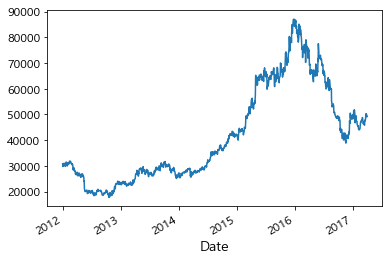

In [213]:
train['064960'].Close.plot()

In [230]:
summation = {}
for feature in predictors:
    summation[feature] = 0
for feature_importance in fi_dict.values():
    for feature in feature_importance.keys():
        summation[feature] += feature_importance[feature]

In [238]:
pd.Series(summation).sort_values(ascending=False).head()

pct_change    45.139429
his_vol_7      7.763847
High           4.929271
Low            4.863120
his_vol_21     4.773967
dtype: float64

In [239]:
test_result2 = {}
fi_dict2 = {}
trial = 0
start = time.time()
for i in train.keys():
    trial += 1
    semi_start = time.time()
    ### 코드 행동 실행
    model, fear_importance, test_pred, test_predprob = modelfit3(stock_alg[i], train[i], test[i], 
                                                                 predictors, target, useTrainCV = True,
                                                                 cv_folds=5, early_stopping_rounds=20,)
    # Calculating Score
    test_result2[i] = np.array([
        metrics.accuracy_score(test[i][target], test_pred),
        metrics.f1_score(test[i][target], test_pred),
        metrics.precision_score(test[i][target], test_pred),
        metrics.recall_score(test[i][target], test_pred),
        metrics.roc_auc_score(test[i][target], test_predprob)
    ])
    fi_dict2[i] = fear_importance
    ### 코드 동작 종료
    print(trial, '번째', code_dict[i])
    semi_elapse = time.time() - semi_start
    elapse = time.time() - start
    if elapse > 3600:
        print(' 지금까지 걸린 시간 {} hour\t'.format(round(elapse/3600,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    elif elapse > 60:
        print(' 지금까지 걸린 시간 {} min\t'.format(round(elapse/60,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    else:
        print(' 지금까지 걸린 시간 {} sec\t'.format(round(elapse,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    print('')

1 번째 AK홀딩스
 지금까지 걸린 시간 1.57 sec	 (+ 1.57 sec)

2 번째 BNK금융지주
 지금까지 걸린 시간 2.8 sec	 (+ 1.23 sec)

3 번째 CJ
 지금까지 걸린 시간 3.71 sec	 (+ 0.91 sec)

4 번째 CJ CGV
 지금까지 걸린 시간 5.68 sec	 (+ 1.98 sec)

5 번째 CJ대한통운
 지금까지 걸린 시간 7.26 sec	 (+ 1.57 sec)

6 번째 CJ제일제당
 지금까지 걸린 시간 10.49 sec	 (+ 3.23 sec)

7 번째 DB손해보험
 지금까지 걸린 시간 13.67 sec	 (+ 3.19 sec)

8 번째 DB하이텍
 지금까지 걸린 시간 17.23 sec	 (+ 3.56 sec)

9 번째 GKL
 지금까지 걸린 시간 18.48 sec	 (+ 1.25 sec)

10 번째 GS
 지금까지 걸린 시간 20.85 sec	 (+ 2.37 sec)

11 번째 GS건설
 지금까지 걸린 시간 22.91 sec	 (+ 2.06 sec)

12 번째 GS리테일
 지금까지 걸린 시간 25.12 sec	 (+ 2.21 sec)

13 번째 JW중외제약
 지금까지 걸린 시간 26.72 sec	 (+ 1.6 sec)

14 번째 JW홀딩스
 지금까지 걸린 시간 28.72 sec	 (+ 1.99 sec)

15 번째 KB금융
 지금까지 걸린 시간 29.94 sec	 (+ 1.23 sec)

16 번째 KCC
 지금까지 걸린 시간 33.36 sec	 (+ 3.42 sec)

17 번째 KT
 지금까지 걸린 시간 35.13 sec	 (+ 1.77 sec)

18 번째 KT&G
 지금까지 걸린 시간 36.55 sec	 (+ 1.42 sec)

19 번째 LF
 지금까지 걸린 시간 38.53 sec	 (+ 1.99 sec)

20 번째 LG
 지금까지 걸린 시간 39.89 sec	 (+ 1.35 sec)

21 번째 LG디스플레이
 지금까지 걸린 시간 43.1 sec	 (+ 3.21 sec)

2

173 번째 현대해상
 지금까지 걸린 시간 6.27 min	 (+ 1.27 sec)

174 번째 현대홈쇼핑
 지금까지 걸린 시간 6.3 min	 (+ 1.7 sec)

175 번째 호텔신라
 지금까지 걸린 시간 6.35 min	 (+ 3.04 sec)

176 번째 후성
 지금까지 걸린 시간 6.39 min	 (+ 2.12 sec)

177 번째 휴켐스
 지금까지 걸린 시간 6.43 min	 (+ 2.57 sec)



In [244]:
summation2 = {}
for feature in predictors:
    summation2[feature] = 0
for feature_importance in fi_dict2.values():
    for feature in feature_importance.keys():
        summation2[feature] += feature_importance[feature]

In [245]:
summation = {}
for feature in predictors:
    summation[feature] = 0
for feature_importance in fi_dict.values():
    for feature in feature_importance.keys():
        summation[feature] += feature_importance[feature]

In [246]:
pd.Series(summation).sort_values(ascending=False).head(10)

pct_change     45.139429
his_vol_7       7.763847
High            4.929271
Low             4.863120
his_vol_21      4.773967
close_ma_3      4.755443
Adj Close       4.600964
Volume          4.046665
his_vol_30      3.807816
volume_ma_3     3.760062
dtype: float64

In [247]:
pd.Series(summation2).sort_values(ascending=False).head(10)

pct_change     46.195482
his_vol_7       7.764463
High            4.983626
Low             4.894153
close_ma_3      4.750412
his_vol_21      4.690878
Adj Close       4.603087
Volume          3.938087
his_vol_30      3.728087
volume_ma_3     3.676569
dtype: float64

In [241]:
pd.DataFrame(test_result, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score']).T.describe()

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
count,177.000000,177.000000,177.000000,177.000000,177.000000
mean,0.884271,0.878696,0.892558,0.869348,0.962053
std,0.021722,0.025631,0.040660,0.055942,0.011560
min,0.802469,0.776224,0.797546,0.660714,0.920940
25%,0.872274,0.863636,0.863905,0.834356,0.955786
50%,0.885802,0.880000,0.893333,0.873418,0.963127
75%,0.898148,0.894737,0.925676,0.911392,0.970454
max,0.938272,0.935484,0.970803,0.964286,0.986613


In [242]:
pd.DataFrame(test_result2, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score']).T.describe()

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
count,177.000000,177.000000,177.000000,177.000000,177.000000
mean,0.884022,0.878532,0.892073,0.869375,0.962010
std,0.021724,0.025199,0.040823,0.054728,0.011551
min,0.802469,0.776224,0.797546,0.660714,0.920940
25%,0.870370,0.863309,0.863636,0.834356,0.955376
50%,0.882716,0.879747,0.893333,0.873418,0.963305
75%,0.898148,0.893891,0.925676,0.912088,0.970432
max,0.938272,0.935484,0.970803,0.964286,0.986613


In [248]:
predictors = ['pct_change', 'his_vol_7', 'High', 'Low', 'close_ma_3', 'his_vol_21']

test_result3 = {}
trial = 0
start = time.time()
for i in train.keys():
    trial += 1
    semi_start = time.time()
    ### 코드 행동 실행
    model, fear_importance, test_pred, test_predprob = modelfit3(stock_alg[i], train[i], test[i], 
                                                                 predictors, target, useTrainCV = True,
                                                                 cv_folds=5, early_stopping_rounds=20,)
    # Calculating Score
    test_result3[i] = np.array([
        metrics.accuracy_score(test[i][target], test_pred),
        metrics.f1_score(test[i][target], test_pred),
        metrics.precision_score(test[i][target], test_pred),
        metrics.recall_score(test[i][target], test_pred),
        metrics.roc_auc_score(test[i][target], test_predprob)
    ])
    ### 코드 동작 종료
    print(trial, '번째', code_dict[i])
    semi_elapse = time.time() - semi_start
    elapse = time.time() - start
    if elapse > 3600:
        print(' 지금까지 걸린 시간 {} hour\t'.format(round(elapse/3600,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    elif elapse > 60:
        print(' 지금까지 걸린 시간 {} min\t'.format(round(elapse/60,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    else:
        print(' 지금까지 걸린 시간 {} sec\t'.format(round(elapse,2)), '(+ {} sec)'.format(round(semi_elapse,2)))
    print('')

1 번째 AK홀딩스
 지금까지 걸린 시간 0.84 sec	 (+ 0.83 sec)

2 번째 BNK금융지주
 지금까지 걸린 시간 1.52 sec	 (+ 0.68 sec)

3 번째 CJ
 지금까지 걸린 시간 2.06 sec	 (+ 0.54 sec)

4 번째 CJ CGV
 지금까지 걸린 시간 3.03 sec	 (+ 0.97 sec)

5 번째 CJ대한통운
 지금까지 걸린 시간 3.49 sec	 (+ 0.46 sec)

6 번째 CJ제일제당
 지금까지 걸린 시간 4.58 sec	 (+ 1.09 sec)

7 번째 DB손해보험
 지금까지 걸린 시간 5.16 sec	 (+ 0.58 sec)

8 번째 DB하이텍
 지금까지 걸린 시간 5.97 sec	 (+ 0.81 sec)

9 번째 GKL
 지금까지 걸린 시간 6.64 sec	 (+ 0.67 sec)

10 번째 GS
 지금까지 걸린 시간 7.11 sec	 (+ 0.47 sec)

11 번째 GS건설
 지금까지 걸린 시간 7.72 sec	 (+ 0.61 sec)

12 번째 GS리테일
 지금까지 걸린 시간 8.35 sec	 (+ 0.63 sec)

13 번째 JW중외제약
 지금까지 걸린 시간 9.19 sec	 (+ 0.84 sec)

14 번째 JW홀딩스
 지금까지 걸린 시간 10.23 sec	 (+ 1.04 sec)

15 번째 KB금융
 지금까지 걸린 시간 10.93 sec	 (+ 0.7 sec)

16 번째 KCC
 지금까지 걸린 시간 12.0 sec	 (+ 1.08 sec)

17 번째 KT
 지금까지 걸린 시간 12.47 sec	 (+ 0.47 sec)

18 번째 KT&G
 지금까지 걸린 시간 12.93 sec	 (+ 0.46 sec)

19 번째 LF
 지금까지 걸린 시간 13.55 sec	 (+ 0.61 sec)

20 번째 LG
 지금까지 걸린 시간 14.27 sec	 (+ 0.72 sec)

21 번째 LG디스플레이
 지금까지 걸린 시간 15.11 sec	 (+ 0.85 sec)

22 번째 LG

172 번째 현대차
 지금까지 걸린 시간 2.12 min	 (+ 0.87 sec)

173 번째 현대해상
 지금까지 걸린 시간 2.13 min	 (+ 0.67 sec)

174 번째 현대홈쇼핑
 지금까지 걸린 시간 2.14 min	 (+ 0.78 sec)

175 번째 호텔신라
 지금까지 걸린 시간 2.16 min	 (+ 1.22 sec)

176 번째 후성
 지금까지 걸린 시간 2.18 min	 (+ 0.69 sec)

177 번째 휴켐스
 지금까지 걸린 시간 2.18 min	 (+ 0.57 sec)



In [249]:
pd.DataFrame(test_result3, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score']).T.describe()

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
count,177.000000,177.000000,177.000000,177.000000,177.000000
mean,0.870121,0.862844,0.883934,0.847437,0.953934
std,0.022833,0.026796,0.043195,0.060097,0.011753
min,0.793210,0.759124,0.782946,0.654088,0.908033
25%,0.858025,0.846154,0.852113,0.808917,0.946350
50%,0.870370,0.863014,0.881657,0.850000,0.955089
75%,0.885802,0.879257,0.919463,0.889610,0.961325
max,0.938272,0.936709,0.982456,0.967532,0.982634


In [266]:
pd.DataFrame(test_result3, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score']).T['recall_score'].argmin()

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  """Entry point for launching an IPython kernel.


'010780'

In [269]:
code_dict['005300'] # 롯데칠성
pd.DataFrame(test_result3, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score'])['005300']
# acc, auc 최소

accuracy_score     0.793210
f1_score           0.795107
precision_score    0.792683
recall_score       0.797546
roc_auc_score      0.908033
Name: 005300, dtype: float64

In [270]:
code_dict['010780'] # 아이에스동서
pd.DataFrame(test_result3, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score'])['010780']
# f1, recall 최소

accuracy_score     0.796296
f1_score           0.759124
precision_score    0.904348
recall_score       0.654088
roc_auc_score      0.937812
Name: 010780, dtype: float64

In [271]:
code_dict['170900'] # 동아에스티
pd.DataFrame(test_result3, index=['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score'])['170900']
# precision 최소

accuracy_score     0.835443
f1_score           0.838174
precision_score    0.782946
recall_score       0.901786
roc_auc_score      0.935214
Name: 170900, dtype: float64

In [250]:
stock_alg

{'006840': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.75, gamma=0, learning_rate=0.15,
        max_delta_step=0, max_depth=2, min_child_weight=2, missing=None,
        n_estimators=112, n_jobs=1, nthread=4, objective='binary:logistic',
        random_state=0, reg_alpha=0.7, reg_lambda=1, scale_pos_weight=1,
        seed=27, silent=True, subsample=0.95),
 '138930': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.75, gamma=0, learning_rate=0.15,
        max_delta_step=0, max_depth=2, min_child_weight=2, missing=None,
        n_estimators=90, n_jobs=1, nthread=4, objective='binary:logistic',
        random_state=0, reg_alpha=0.7, reg_lambda=1, scale_pos_weight=1,
        seed=27, silent=True, subsample=0.95),
 '001040': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.75, gamma=0, learning_rate=0.15,
        max_delta_step=0, max_depth=2, min_

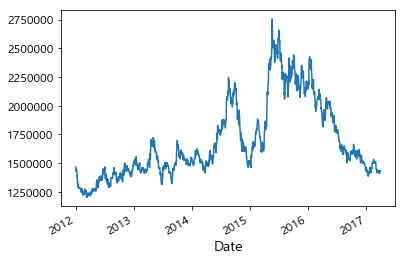

In [272]:
train['005300'].Close.plot()

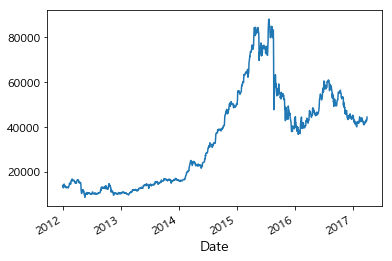

In [273]:
train['010780'].Close.plot()

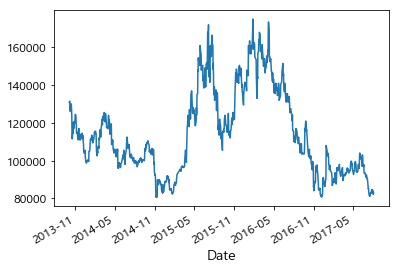

In [274]:
train['170900'].Close.plot()